In [4]:
import gzip
import matplotlib.pyplot as plt
import numpy
import struct
import time
import random
import urllib.request

def getData(fileName):
    file = gzip.open(fileName, 'r')
    file.read(4)
    numImages = struct.unpack('>i', file.read(4))[0]
    numRows = struct.unpack('>i', file.read(4))[0]
    numColumns = struct.unpack('>i', file.read(4))[0]
    
    buffer = file.read(numImages * numRows * numColumns)
    data = numpy.frombuffer(buffer, dtype = numpy.uint8)
    data = data.reshape(numImages, numRows * numColumns)

    return data, numImages, numRows, numColumns

def getLabels(fileName):
    file = gzip.open(fileName, 'r')
    file.read(4)
    numImages = struct.unpack('>i', file.read(4))[0]
    
    buffer = file.read(numImages)
    data = numpy.frombuffer(buffer, dtype = numpy.uint8)
    labels = numpy.zeros((numImages, 10))
    for i in range(numImages):
        labels[i][data[i]] = 1
        
    return labels

def train(trainData, trainLabels, numTrainImages, testData, testLabels, numTestImages, weightRowSize, iterations, batchSize, learningRate):

    W = numpy.zeros((weightRowSize, 10))
    
    if numTrainImages == 0:
        return W
    
    losses = []
    accuracies = []
    for i in range(iterations):
        indices = numpy.random.choice(numTrainImages, batchSize)
        X = trainData[indices]
        Y = trainLabels[indices]
        
        loss = 0
        norm = Y - X.dot(W)
        for i in norm:
            for j in i:
                loss += j**2
        loss /= 2 * batchSize
        losses.append(loss)
        
        if numTestImages > 0:
            accuracy = 0
            predictedLabels = testData.dot(W)
            for predictedLabel, testLabelIndex in zip(predictedLabels, range(numTestImages)):
                maxIndex = numpy.argmax(predictedLabel)
                if (predictedLabel.size == 1 or predictedLabel[maxIndex] > numpy.amax(numpy.delete(predictedLabel, maxIndex))) and testLabels[testLabelIndex][maxIndex] == 1:
                    accuracy += 1
            accuracy /= numTestImages
            accuracies.append(accuracy)
        
        W -= learningRate * (1 / batchSize) * (numpy.transpose(X).dot(X.dot(W)) - numpy.transpose(X).dot(Y))
    
    return losses, accuracies

iterations = 1000
learningRate = 10**-10
batchSizes = [1, 10, 100, 1000]
datasetSizes = [100, 500, 1000, 10000]
testSize = 10000

iterationVariables = numpy.arange(1, iterations + 1)

print('Initialization complete')

Initialization complete


In [5]:
website = 'http://yann.lecun.com/exdb/mnist/'
files = ['train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz', 't10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz']
for file in files:
    url = website + file
    urllib.request.urlretrieve(url, file)

trainData, numTrainImages, numRows, numColumns= getData(files[0])
trainLabels = getLabels(files[1])
testData, numTestImages, _, _ = getData(files[2])
testLabels = getLabels(files[3])

print('File downloading and formatting complete')

File download and formatting complete


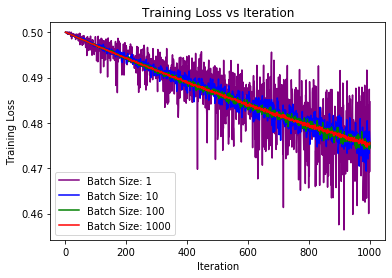

In [2]:
batchSizeLosses = []
batchSizeTimes = []
for size in batchSizes:
    startTime = time.time()
    loss, _ = train(trainData, trainLabels, numTrainImages, [], [], 0, numRows * numColumns, iterations, size, learningRate)
    endTime = time.time()
    batchSizeLosses.append(loss)
    batchSizeTimes.append(endTime - startTime)

plt.plot(iterationVariables, batchSizeLosses[0], label = 'Batch Size: 1', color = 'purple')
plt.plot(iterationVariables, batchSizeLosses[1], label = 'Batch Size: 10', color = 'blue')
plt.plot(iterationVariables, batchSizeLosses[2], label = 'Batch Size: 100', color = 'green')
plt.plot(iterationVariables, batchSizeLosses[3], label = 'Batch Size: 1000', color = 'red')
plt.title('Training Loss vs Iteration')
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.legend()
plt.show()

In [8]:
for size, timing in zip(batchSizes, batchSizeTimes):
    print('Time to compute batch size ', size, ': ', timing, ' seconds', sep = '')

Time to compute batch size 1: 0.12697529792785645 seconds
Time to compute batch size 10: 0.22667169570922852 seconds
Time to compute batch size 100: 1.1194682121276855 seconds
Time to compute batch size 1000: 23.019293308258057 seconds


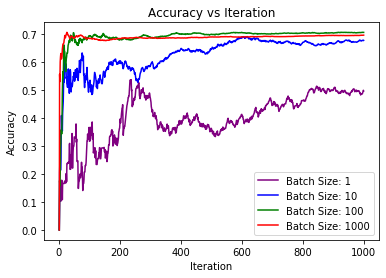

In [4]:
batchSizeAccuracies = []
for size in batchSizes:
    if testSize < numTestImages:
        indices = numpy.random.choice(numTestImages, testSize)
        testDataSubset = testData[indices]
        testLabelSubset = testLabels[indices]
    else:
        testDataSubset = testData
        testLabelSubset = testLabels
        testSize = numTestImages
    
    _, accuracy = train(trainData, trainLabels, numTrainImages, testDataSubset, testLabelSubset, testSize, numRows * numColumns, iterations, size, learningRate)
    batchSizeAccuracies.append(accuracy)

plt.plot(iterationVariables, batchSizeAccuracies[0], label = 'Batch Size: 1', color = 'purple')
plt.plot(iterationVariables, batchSizeAccuracies[1], label = 'Batch Size: 10', color = 'blue')
plt.plot(iterationVariables, batchSizeAccuracies[2], label = 'Batch Size: 100', color = 'green')
plt.plot(iterationVariables, batchSizeAccuracies[3], label = 'Batch Size: 1000', color = 'red')
plt.title('Accuracy vs Iteration')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

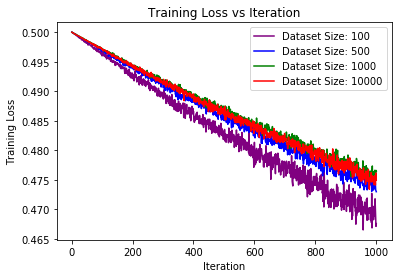

In [5]:
datasetSizeLosses = []
datasetSizeTimes = []
for size in datasetSizes:
    if size < numTrainImages:
        indices = numpy.random.choice(numTrainImages, size, replace = False)
        trainDataSubset = trainData[indices]
        trainLabelSubset = trainLabels[indices]
    else:
        trainDataSubset = trainData
        trainLabelSubset = trainLabels
        size = numTrainImages
    
    startTime = time.time()
    loss, _ = train(trainDataSubset, trainLabelSubset, size, [], [], 0, numRows * numColumns, iterations, 100, learningRate)
    endTime = time.time()
    datasetSizeLosses.append(loss)
    datasetSizeTimes.append(endTime - startTime)

plt.plot(iterationVariables, datasetSizeLosses[0], label = 'Dataset Size: 100', color = 'purple')
plt.plot(iterationVariables, datasetSizeLosses[1], label = 'Dataset Size: 500', color = 'blue')
plt.plot(iterationVariables, datasetSizeLosses[2], label = 'Dataset Size: 1000', color = 'green')
plt.plot(iterationVariables, datasetSizeLosses[3], label = 'Dataset Size: 10000', color = 'red')
plt.title('Training Loss vs Iteration')
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.legend()
plt.show()

In [9]:
for size, timing in zip(datasetSizes, datasetSizeTimes):
    print('Time to compute dataset size ', size, ': ', timing, ' seconds', sep = '')

Time to compute dataset size 100: 1.0753250122070312 seconds
Time to compute dataset size 500: 1.0366370677947998 seconds
Time to compute dataset size 1000: 1.135836124420166 seconds
Time to compute dataset size 10000: 1.066396713256836 seconds


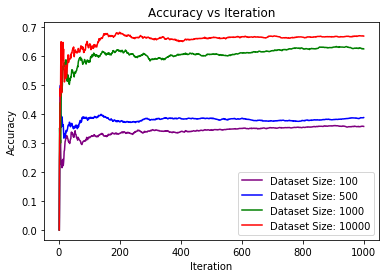

In [8]:
datasetSizeAccuracies = []
for size in datasetSizes:
    if size < numTrainImages:
        indices = numpy.random.choice(numTrainImages, size, replace = False)
        trainDataSubset = trainData[indices]
        trainLabelSubset = trainLabels[indices]
    else:
        trainDataSubset = trainData
        trainLabelSubset = trainLabels
    
    if testSize < numTestImages:
        indices = numpy.random.choice(numTestImages, testSize)
        testDataSubset = testData[indices]
        testLabelSubset = testLabels[indices]
    else:
        testDataSubset = testData
        testLabelSubset = testLabels
        testSize = numTestImages
    
    _, accuracy = train(trainDataSubset, trainLabelSubset, size, testDataSubset, testLabelSubset, testSize, numRows * numColumns, iterations, 100, learningRate)
    datasetSizeAccuracies.append(accuracy)

plt.plot(iterationVariables, datasetSizeAccuracies[0], label = 'Dataset Size: 100', color = 'purple')
plt.plot(iterationVariables, datasetSizeAccuracies[1], label = 'Dataset Size: 500', color = 'blue')
plt.plot(iterationVariables, datasetSizeAccuracies[2], label = 'Dataset Size: 1000', color = 'green')
plt.plot(iterationVariables, datasetSizeAccuracies[3], label = 'Dataset Size: 10000', color = 'red')
plt.title('Accuracy vs Iteration')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.show()